# Trying to understand the approximations of Holt Winters

In [1]:
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
sns.set_context('notebook') 
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
green='#00FF00'
orange='#FFA500'
%matplotlib inline

In [3]:
plt.rcParams['figure.figsize'] = [15, 10]

### First series, with trend and seasonality

In [4]:
data=pd.read_csv('datasets/AirPassengers.csv', index_col='Month', parse_dates=True)
data.index=data.index.to_period(freq='M')
data.head(), data.tail()

(         #Passengers
 Month               
 1949-01          112
 1949-02          118
 1949-03          132
 1949-04          129
 1949-05          121,          #Passengers
 Month               
 1960-08          606
 1960-09          508
 1960-10          461
 1960-11          390
 1960-12          432)

In [5]:
y=data['#Passengers']

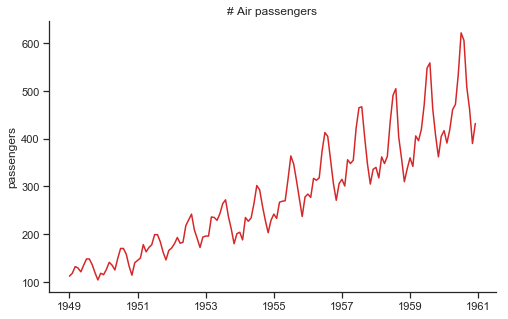

In [6]:
fig, ax= plt.subplots(figsize=(8,5))
y.plot(color=red)
ax.set_xlabel('')
ax.set_ylabel('passengers')
ax.set_title('# Air passengers')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

In [7]:
def my_holt(y, l0, b0, alpha, beta):
    observations = np.array(y)
    l = pd.Series(np.zeros(y.shape), index=y.index)
    b = pd.Series(np.zeros(y.shape), index=y.index)
    predictions = pd.Series(np.zeros(y.shape), index=y.index + 1)
    l[0] = l0
    b[0] = b0
    for t in range(len(y)-1):
        l[t] = alpha * y[t] + (1 - alpha) * (l[t-1] + b[t-1])
        b[t] = beta * (l[t] - l[t-1]) + (1 - beta) * b[t-1]
        predictions[t+1] = l[t] + b[t]
    return predictions, l, b

In [8]:
def plot_my_holt(y, l0, b0, alpha, beta):
    predictions, l, b = my_holt(y, l0, b0, alpha, beta)
    fig, ax= plt.subplots(figsize=(15,10))
    y[1:-1].plot(color=red, label='Original')
    predictions[1:-1].plot(color=green, label='Predictions')
    l[1:-1].plot(color=blue, label='l')
    b[1:-1].plot(color=orange, label='b')
    ax.set_xlabel('')
    ax.set_ylabel('passengers')
    ax.set_title('# Holt analysis')
    ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
    plt.legend(loc='best')
    sns.despine()
    plt.show()
    return predictions, l, b

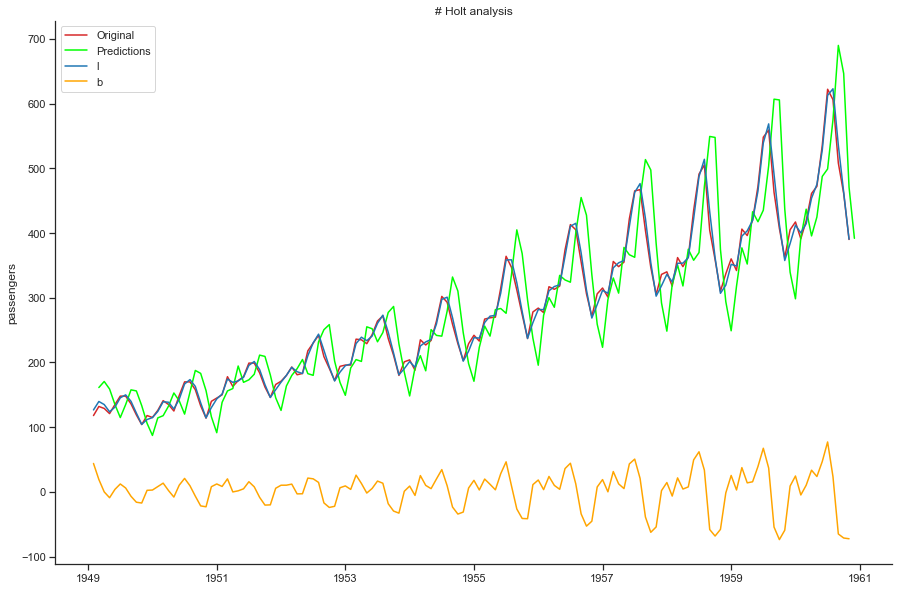

In [9]:
pred, l, b = plot_my_holt(y, y[0], y[1] - y[0], 0.8, 0.8)

In [10]:
def my_holt_winters(y, L, l0, b0, Si, alpha, beta, delta):
    def access_S(i):
        if i < 0:
            return Si[i]
        return S[i]
    observations = np.array(y)
    l = pd.Series(np.zeros(y.shape), index=y.index)
    b = pd.Series(np.zeros(y.shape), index=y.index)
    S = pd.Series(np.zeros(y.shape), index=y.index)
    predictions = pd.Series(np.zeros(y.shape), index=y.index + 1)
    l[0] = l0
    b[0] = b0
    for t in range(len(y)-1):
        l[t] = alpha * (y[t] - access_S(t-L)) + (1 - alpha) * (l[t-1] + b[t-1])
        b[t] = beta * (l[t] - l[t-1]) + (1 - beta) * b[t-1]
        S[t] = delta * (y[t] - l[t]) + (1 - delta) * access_S(t-L)
        predictions[t+1] = l[t] + b[t] + access_S(t+1-L)
    return predictions, l, b, S

In [11]:
def plot_my_holt_winters(y, L, l0, b0, Si, alpha, beta, delta):
    predictions, l, b, S = my_holt_winters(y, L, l0, b0, Si, alpha, beta, delta)
    plt.rcParams['figure.figsize'] = [25, 25]
    plt.subplot(2,2,1)
    y[1:-1].plot(color=red, label='Original')
    predictions[1:-1].plot(color=green, label='Predictions')
    plt.legend(loc='best')
    plt.subplot(2,2,2)
    y[1:-1].plot(color=red, label='Original')
    l[1:-1].plot(color=blue, label='l')
    plt.legend(loc='best')
    plt.subplot(2,2,3)
    y[1:-1].plot(color=red, label='Original')
    b[1:-1].plot(color=orange, label='b')
    plt.legend(loc='best')
    plt.subplot(2,2,4)
    y[1:-1].plot(color=red, label='Original')
    S[1:-1].plot(color='yellow', label='S')
    plt.legend(loc='best')
#     ax.set_xlabel('')
#     ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
    sns.despine()
    plt.show()
    return predictions, l, b, S

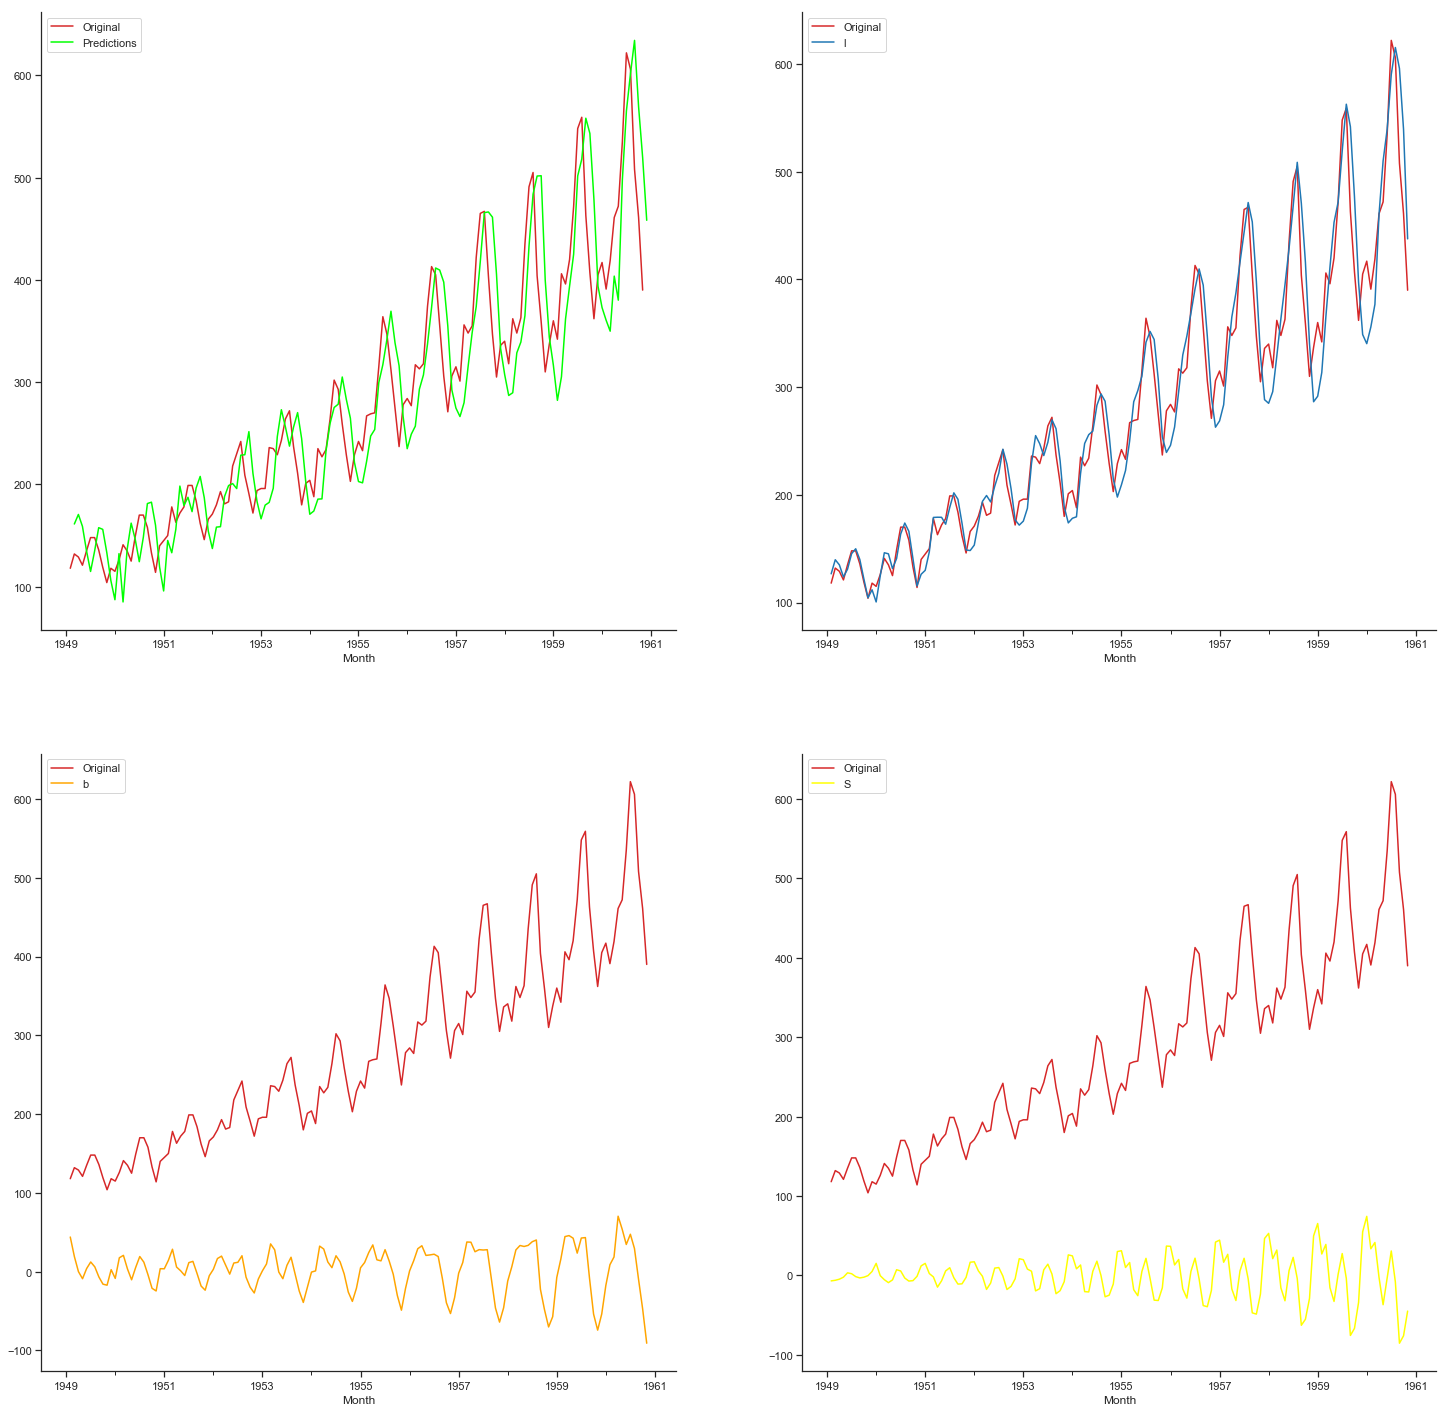

In [12]:
pred, l, b, S = plot_my_holt_winters(y, 12, y[0], y[1] - y[0], np.zeros((12,)), 0.8, 0.8, 0.8)

### Second, only seasonality

In [13]:
data=pd.read_csv('datasets/daily-minimum-temperatures-in-me.csv', index_col='Date', parse_dates=True)
data.index=data.index.to_period(freq='D')
data.tail()

,"Daily minimum temperatures in Melbourne, Australia, 1981-1990"
Date,
1990-12-27,14.0
1990-12-28,13.6
1990-12-29,13.5
1990-12-30,15.7
1990-12-31,13.0


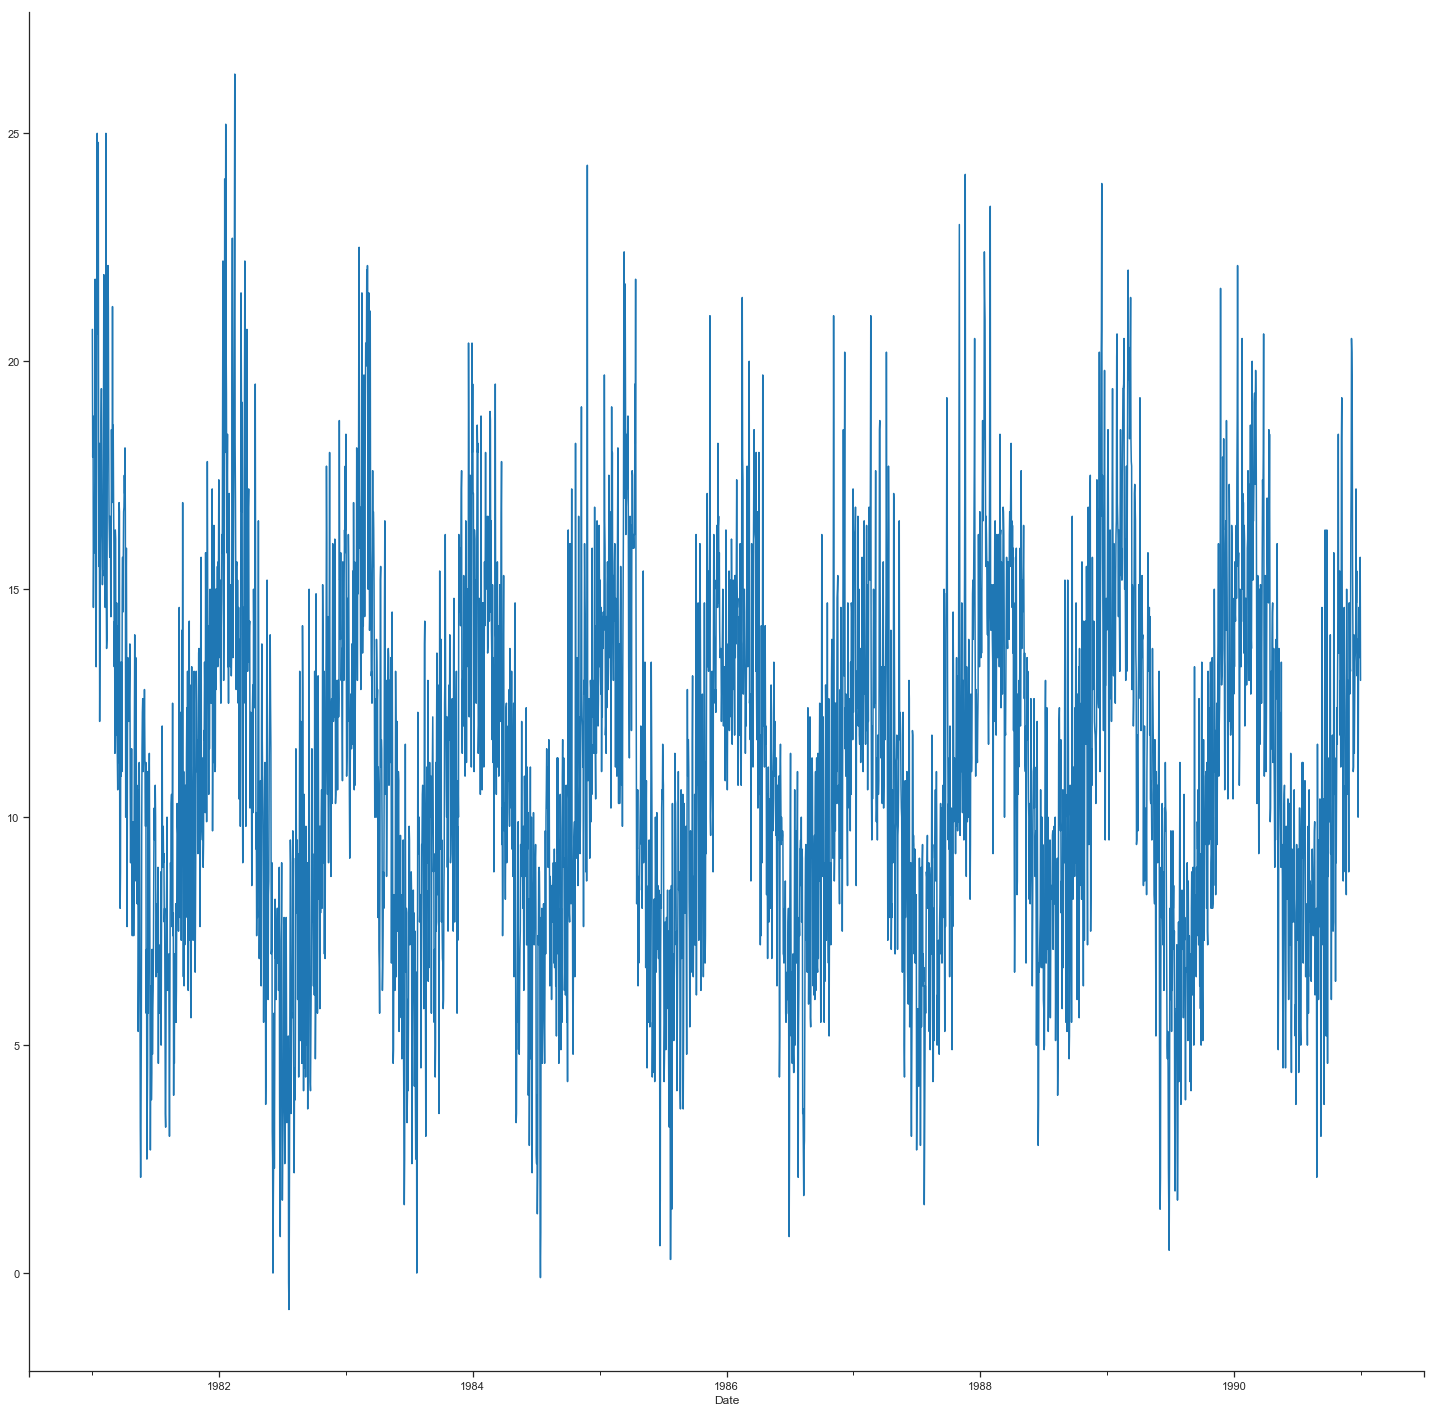

In [14]:
y2 = data["Daily minimum temperatures in Melbourne, Australia, 1981-1990"]
y2.plot()
sns.despine()

The series is very irregular, we smooth it somehow:

In [15]:
y2 = y2.groupby(pd.Grouper(freq="M"))
y2 = y2.mean()

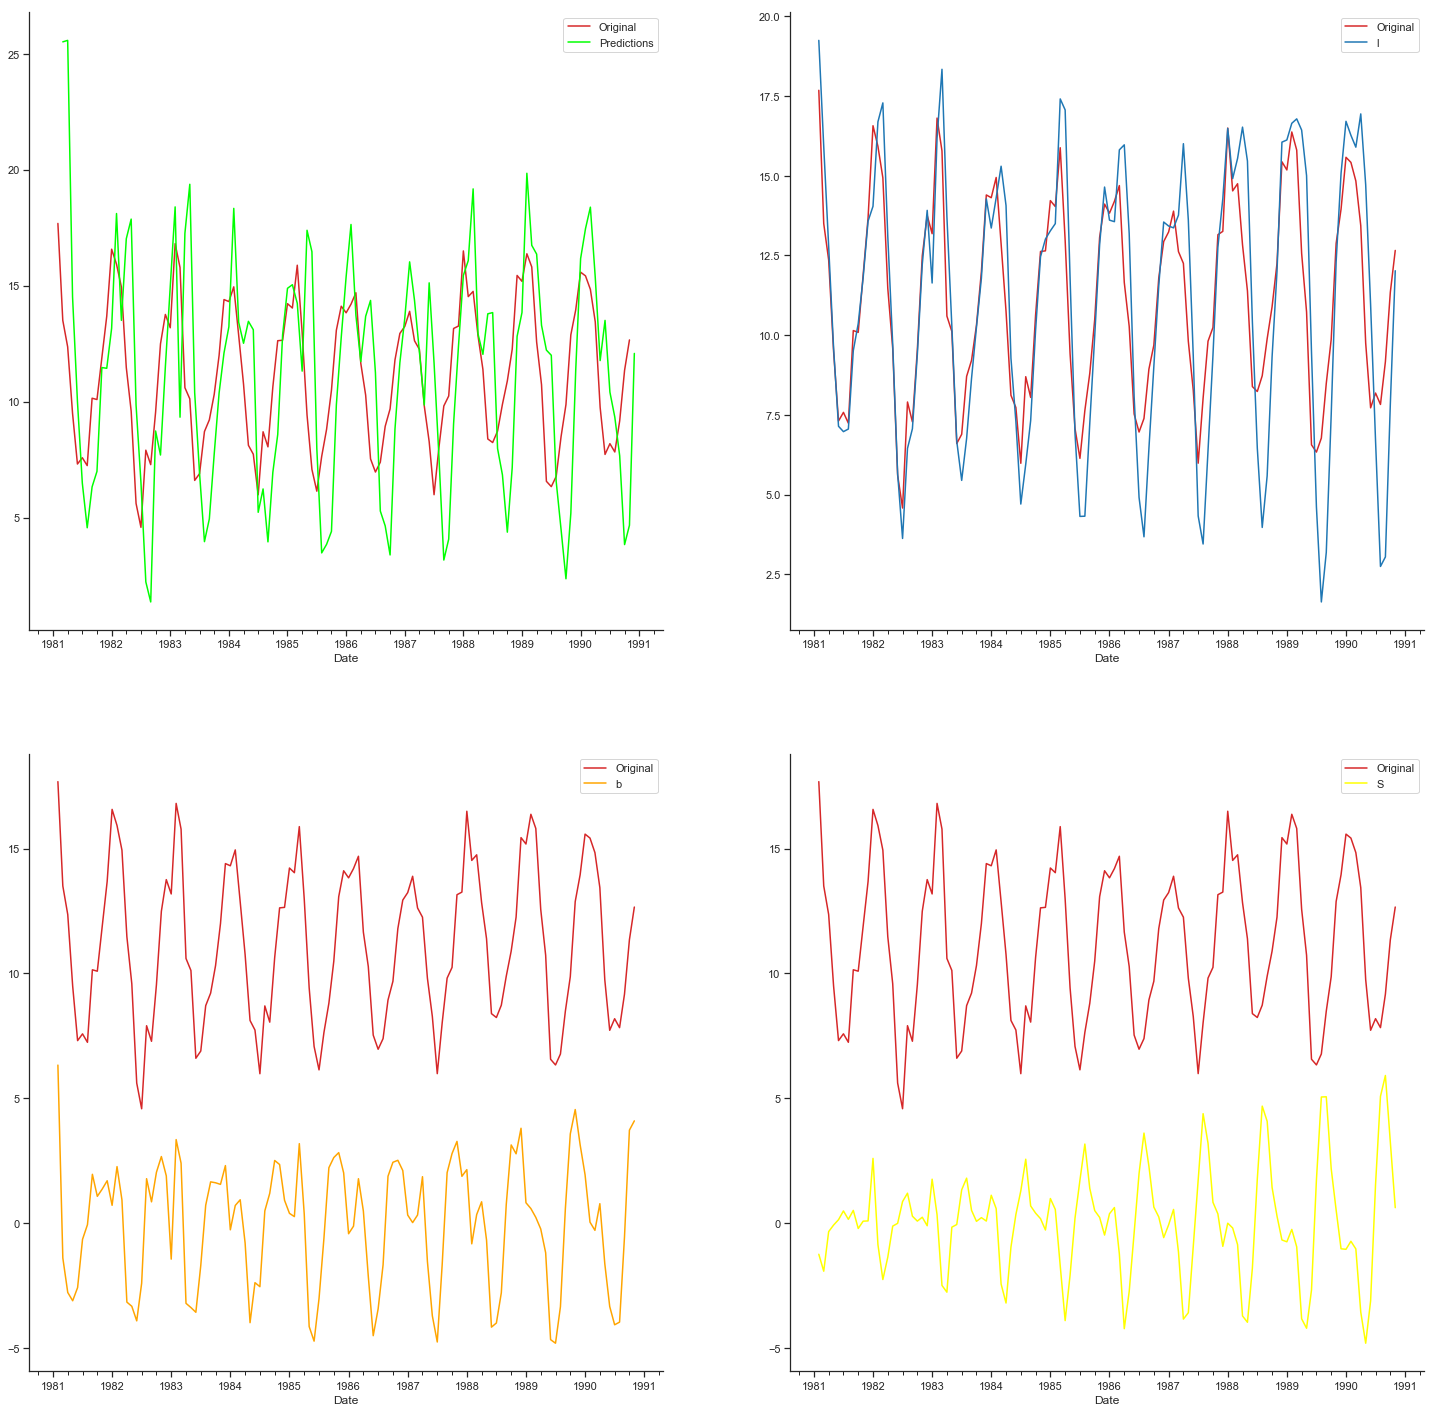

In [16]:
pred, l, b, S = plot_my_holt_winters(y2, 12, y2[0], y2[1] - y2[0], np.zeros((12,)), 0.8, 0.8, 0.8)